Find the optimal number of hidden neurons for the first depth and widths of the neural network designed in Question 1 and 2.

#### Plot the mean cross-validation accuracies on the final epoch for at least 8 different combinations of different depth (limit to 1-3 layers) and widths (limit to 64, 128 or 256 neurons) using a scatter plot. Continue using 5-fold cross validation on the training dataset. Select the optimal number of neurons for the hidden layer. State the rationale for your selection. Plot the train and test accuracies against training epochs with the optimal number of neurons using a line plot. [optional + 2 marks] Implement an alternative approach that searches through these combinations that could significantly reduce the computational time but achieve similar search results, without enumeration all the possibilities.



This might take a while to run, approximately 30 - 60 min, so plan your time carefully.

1.Firstly, we import relevant libraries.

In [86]:
import tqdm
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from scipy.io import wavfile as wav

from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
from common_utils import set_seed

# setting seed
set_seed()

2.To reduce repeated code, place your

- network (MLP defined in QA1)
- torch datasets (CustomDataset defined in QA1)
- loss function (loss_fn defined in QA1)

in a separate file called **common_utils.py**

Import them into this file. You will not be repenalised for any error in QA1 here as the code in QA1 will not be remarked.

The following code cell will not be marked.

In [87]:
# Modify the model to accept varied number of layers 
class MLP(nn.Module):

    def __init__(self, no_features, no_hidden, no_labels, depth):
        super().__init__()
        layers = [] # List of layers 

        # Input layer
        layers.append(nn.Linear(no_features, no_hidden))
        layers.append(nn.ReLU())
        layers.append(nn.Dropout(p=0.2))

        # Varied Hidden layers 
        for _ in range(depth - 1): 
            layers.append(nn.Linear(no_hidden, no_hidden))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(p=0.2))

        # Output layer
        layers.append(nn.Linear(no_hidden, no_labels))
        layers.append(nn.Sigmoid())  

        # Unpacks the list into the respective layers in the sequential stack 
        self.mlp_stack = nn.Sequential(*layers) 

    def forward(self, x):
        return self.mlp_stack(x)


In [88]:
from common_utils import CustomDataset, preprocess_dataset, EarlyStopper, preprocess


# Binary Cross Entropy Loss for binary classification
loss_fn = nn.BCELoss()

# Read the dataset
df = pd.read_csv('simplified.csv')

# Create the label from the filename since filename contains the label
df['label'] = df['filename'].str.split('_').str[-2]

# From the dataset given, we will drop filename and label since filename doesn't provide any detail and label is the prediction task
col_drop = ["filename", "label"]

# Preprocess the dataset (split and scale)
X_train_scaled, y_train, X_test_scaled, y_test = preprocess(df, col_drop= col_drop)

In [89]:
X_train_scaled.shape

(9645, 77)

In [90]:
X_test_scaled.shape

(2412, 77)

In [91]:
df.shape

(12057, 79)

In [92]:
# Initialize the DataLoaders
def intialise_dataloader(X_train_scaled_fold, y_train_fold, X_val_scaled_fold, y_val__fold, batch_size):
    """
    Args:
        X_train_scaled_fold (ndarray): Scaled input features for training for a fold.
        y_train_fold (ndarray): Training labels for a fold.
        X_val_scaled_fold (ndarray): Scaled input features for testing for a fold.
        y_val__fold (ndarray): Test labels for a fold.
        batch_size (int): Batch size for loading the data.

    Returns:
        train_dataloader (DataLoader): Dataloader for the training set.
        validation_dataloader (DataLoader): Dataloader for the validation set.
    """
    # Create instances of the CustomDataset for training and testing
    train_dataset = CustomDataset(X_train_scaled_fold, y_train_fold)
    val_dataset = CustomDataset(X_val_scaled_fold, y_val__fold)

    # Create DataLoaders for training and testing
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    validation_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    return train_dataloader, validation_dataloader

def training_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)

    train_loss, correct_predictions = 0, 0  # Track the number of correct predictions
    total_samples = 0  # Track the total number of samples processed

    for _, (x, y) in enumerate(dataloader):
        # forward pass 
        pred = model(x)

        # Reshape the target labels to match the shape of the predictions
        y = y.unsqueeze(1).float()

        # Calculate the loss
        loss = loss_fn(pred, y)
        optimizer.zero_grad()

        # Backpropagation and optimization step
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        # Convert the predicted probabilities into binary predictions (0 or 1)
        predicted_labels = (pred > 0.5).float()

        # Calculate the number of correct predictions
        correct_predictions += (predicted_labels == y).type(torch.float).sum().item()
        total_samples += y.size(0)  # Keep track of the number of samples

    # Average the loss over the number of batches
    train_loss /= len(dataloader)
    
    # Calculate accuracy by dividing correct predictions by the total number of samples
    accuracy = correct_predictions / total_samples

    return train_loss, accuracy


def validation_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)

    val_loss, correct_predictions = 0, 0  # Track correct predictions and total samples
    total_samples = 0

    with torch.no_grad():
        for x, y in dataloader:
            pred = model(x)

            # Reshape the target labels to match the shape of the predictions
            y = y.unsqueeze(1).float()

            # Calculate the validation loss
            val_loss += loss_fn(pred, y).item()

            # Convert the predicted probabilities into binary predictions (0 or 1)
            predicted_labels = (pred > 0.5).float()

            # Calculate the number of correct predictions
            correct_predictions += (predicted_labels == y).type(torch.float).sum().item()
            total_samples += y.size(0)  # Track the number of samples

    # Average the loss over the number of batches
    val_loss /= len(dataloader)

    # Calculate accuracy by dividing correct predictions by the total number of samples
    accuracy = correct_predictions / total_samples

    return val_loss, accuracy

3.Perform hyperparameter tuning for the different neurons with 5-fold cross validation.

Hyperparameter to tune 
- Number of layers (1,2,3)
- Width of hidden layer (64, 128, 256) 

Total number of combination = 3C1 x 3C1 = 9. 

Batch size to be used is 256 from A2.

Since larger width hidden layer and higher depth models has a higher model complexity. 

To ensure that the model converge to the global optimal, i will increase patience and reduce min_delta for these combinations to allow the model enough time to settle down and avoid premature stopping 

Models with 128 neurons per hidden layer at depth 2 or more will have greater patience and reduce min_delta 

In [93]:
def train(model, X_train_scaled, y_train, X_val_scaled, y_val, batch_size, patience, min_delta):
    """
    Used to do the mini-batch training for each fold.

    Args:
        model: Model of to be use for this fold, with the appropriate depth and width
        X_train_scaled (ndarray): Scaled input features for training for a fold.
        y_train (ndarray): Training labels for a fold.
        X_val_scaled (ndarray): Scaled input features for testing for a fold.
        y_val (ndarray): Test labels for a fold.
        batch_size (int): Batch size for loading the data.
    
    Return: 
        train_accuracies: training accuracy for current fold.
        train_losses: training loss for current fold.
        test_accuracies: testing accuracy for current fold.
        test_losses: testing loss for current fold.
        times: time taken to train each epoch for current fold.
    """
    lr = 0.001
    no_epochs = 100
    train_dataloader, test_dataloader = intialise_dataloader(X_train_scaled, y_train, X_val_scaled, y_val, batch_size)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    early_stopper = EarlyStopper(patience=patience, min_delta=min_delta)

    train_accuracies, train_losses, test_accuracies, test_losses, times = [], [], [], [], []
    
    for epoch in range(no_epochs):
        #training
        start = time.time()
        train_loss_, train_acc_ = training_loop(train_dataloader, model, loss_fn, optimizer)
        test_loss_, test_acc_ = validation_loop(test_dataloader, model, loss_fn)

        train_losses.append(train_loss_), train_accuracies.append(train_acc_)
        test_losses.append(test_loss_), test_accuracies.append(test_acc_)

        times.append(time.time() - start)
        if early_stopper.early_stop(test_loss_):
            print(f"Early Stop occur at epoch {epoch}")
            break
        
    print(f"\t\tTrain Acc: {train_acc_:.4f}\tTest Acc: {test_acc_:.4f}\tTrain Loss: {train_loss_:.4f}\tTest Loss: {test_loss_:.4f}\tTime: {times[-1]:.4f}")
    return train_accuracies, train_losses, test_accuracies, test_losses, times

In [94]:
def find_optimal_hyperparameter(X_train, y_train, num_neurons, num_layers, batch_size):
    """
    Format the dictionary such that 

    cross_validation_accuracies = {
        'train_acc': {
            (neurons, layers): {'data': [fold_1_accuracy_epoch_1, fold_1_accuracy_epoch_2,...], 
                                        [fold_2_accuracy_epoch_1, fold_2_accuracy_epoch_2...],
                                        ... },  # Training accuracy for each fold
            ...
        },
        'train_loss': {
            (neurons, layers): {'data': [fold_1_loss, fold_2_loss, ...},  # Training loss for each fold
            ...
        },
        'test_acc': {
            (neurons, layers): {'data': [fold_1_acc, fold_2_acc, ...},  # Test accuracy for each fold
            ...
        },
        'test_loss': {
            (neurons, layers): {'data': [fold_1_loss, fold_2_loss, ...},  # Test loss for each fold
            ...
        }
    }

    """
    cross_validation_accuracies, cross_validation_times = {}, {}
    
    train_acc_dict, test_acc_dict = {}, {}
    train_loss_dict, test_loss_dict = {}, {}
    cross_validation_times = {}

    for hidden_layer in num_layers:  # Loop over number of layers
        
        for first_hidden in range(len(num_neurons)):  # For each hidden layer 
            neuron_count = num_neurons[first_hidden]
            print("================================================================================================")
            print(f"Number of hidden neurons in first layer: {neuron_count}, Number of hidden layers: {hidden_layer}")
            print("------------------------------------------------------------------------------------------------")
            
            # Perform 5-Fold
            kf = KFold(n_splits=5, shuffle=True, random_state=1)
            training_acc_per_fold, test_acc_per_fold = [], []
            training_loss_per_fold, test_loss_per_fold = [], []
            time_taken_per_fold = []
            fold = 0
            patience = 5
            min_delta = 0

            if (hidden_layer >= 2 and neuron_count >= 128):
                patience = 10
                min_delta = 1e-4
                

            for train_idx, test_idx in kf.split(X_train, y_train):
                print(f"\tFold: {fold}")
                x_train, x_test = X_train[train_idx], X_train[test_idx]
                new_y_train, new_y_test = y_train[train_idx], y_train[test_idx]

                # Modify the MLP to take varying layers
                model = MLP(77, no_hidden=neuron_count, no_labels=1, depth=hidden_layer)

                train_acc_, train_loss_, test_acc_, test_loss_, time_taken_ = train(
                    model, x_train, new_y_train, x_test, new_y_test, batch_size, patience, min_delta
                )

                training_acc_per_fold.append(train_acc_), test_acc_per_fold.append(test_acc_)
                training_loss_per_fold.append(train_loss_), test_loss_per_fold.append(test_loss_)
                time_taken_per_fold.append(time_taken_)
                fold += 1

            # Store results for this combination of neurons and layers
            key = (neuron_count, hidden_layer)  # Use (neurons, layers) as a key

            train_acc_dict[key] = {}
            test_acc_dict[key] = {}
            train_loss_dict[key] = {}
            test_loss_dict[key] = {}
            cross_validation_times[key] = {}

            train_acc_dict[key]['data'] = training_acc_per_fold
            test_acc_dict[key]['data'] = test_acc_per_fold
            train_loss_dict[key]['data'] = training_loss_per_fold
            test_loss_dict[key]['data'] = test_loss_per_fold
            cross_validation_times[key]['data'] = time_taken_per_fold

    cross_validation_accuracies['train_acc'] = train_acc_dict
    cross_validation_accuracies['train_loss'] = train_loss_dict
    cross_validation_accuracies['test_acc'] = test_acc_dict
    cross_validation_accuracies['test_loss'] = test_loss_dict
    
    return cross_validation_accuracies, cross_validation_times


optimal_bs = 256
num_neurons = [64, 128, 256]
num_layers = [1, 2, 3]  

cross_validation_accuracies, cross_validation_times = find_optimal_hyperparameter(X_train_scaled, y_train, num_neurons, num_layers, optimal_bs)


Number of hidden neurons in first layer: 64, Number of hidden layers: 1
------------------------------------------------------------------------------------------------
	Fold: 0
Early Stop occur at epoch 24
		Train Acc: 0.6938	Test Acc: 0.6267	Train Loss: 0.5808	Test Loss: 0.6347	Time: 0.0809
	Fold: 1
Early Stop occur at epoch 34
		Train Acc: 0.7125	Test Acc: 0.6589	Train Loss: 0.5627	Test Loss: 0.6212	Time: 0.0900
	Fold: 2
Early Stop occur at epoch 36
		Train Acc: 0.7071	Test Acc: 0.6542	Train Loss: 0.5605	Test Loss: 0.6138	Time: 0.0850
	Fold: 3
Early Stop occur at epoch 22
		Train Acc: 0.6823	Test Acc: 0.6309	Train Loss: 0.5872	Test Loss: 0.6410	Time: 0.0830
	Fold: 4
Early Stop occur at epoch 41
		Train Acc: 0.7259	Test Acc: 0.6553	Train Loss: 0.5458	Test Loss: 0.6152	Time: 0.0780
Number of hidden neurons in first layer: 128, Number of hidden layers: 1
------------------------------------------------------------------------------------------------
	Fold: 0
Early Stop occur at epoch 3

4. Plot the mean cross-validation accuracies on the final epoch for at least 8 different combinations of different depth (limit to 1-3 layers) and widths (limit to 64, 128 or 256 neurons) using a scatter plot. 

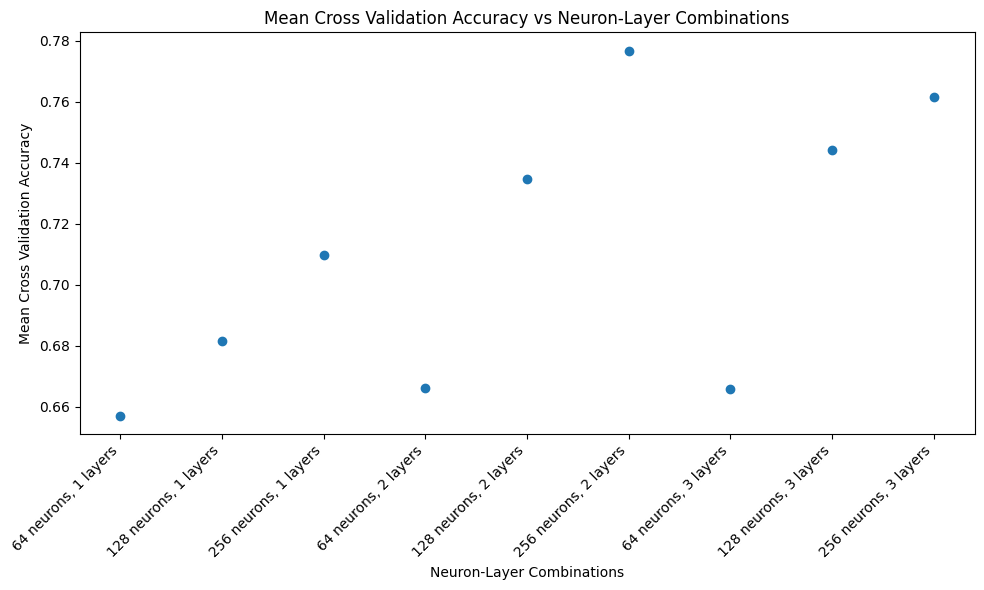

In [95]:
from itertools import chain

def plot_mean_accuracies(cross_validation_accuracies):
    neuron_layer_combinations = []
    mean_accuracies = []

    # Iterate over the 'test_acc' dictionary and calculate the mean accuracy for each combination
    for (neurons, layers), values in cross_validation_accuracies['train_acc'].items():
        # Flatten the list of lists using itertools.chain or numpy.concatenate
        flattened_values = list(chain(*values['data']))  # Flatten the nested list into a single list

        # Now calculate the mean accuracy across all folds/epochs
        mean_accuracy = np.mean(flattened_values)

        # Create a label for each combination
        combination_label = f'{neurons} neurons, {layers} layers'
        neuron_layer_combinations.append(combination_label)
        mean_accuracies.append(mean_accuracy)

    # Plotting code (e.g., matplotlib)
    plt.figure(figsize=(10, 6))
    plt.scatter(neuron_layer_combinations, mean_accuracies)
    plt.xlabel('Neuron-Layer Combinations')
    plt.ylabel('Mean Cross Validation Accuracy')
    plt.xticks(rotation=45, ha='right')
    plt.title('Mean Cross Validation Accuracy vs Neuron-Layer Combinations')
    plt.tight_layout()
    plt.show()

# Call the function
plot_mean_accuracies(cross_validation_accuracies)


5. Select the optimal combination for the depth and width. State the rationale for your selection.

In [96]:
optimal_combination = [2, 256]
reason = """
From the result, 
    256 neurons and 2 layers is the optimal combination for the depth and width as since from the highest Mean
    Cross Validation Accuracy graph as shown above.

Having a more complex architecture generally yields better cross-validation accuracy, (i.e. 256 neurons 2 layers) 
can capture more complex pattern in the data, which is able to better generalise the dataset and resulting in higher
accuracy

However, if the architecture is too complex for the given task, the model might tend to overfit the dataset as it has
the capacity to memorise the pattern instead of generalizing well to new data. given the higher complexity of the model
"""

# YOUR CODE HERE

6.Plot the train and test accuracies against training epochs with the optimal number of neurons using a line plot.


In [97]:
def plot_accuracies_over_epochs(train_acc_dict, test_acc_dict, optimal_neurons, optimal_layers):
    key = (optimal_neurons, optimal_layers)  # Use the optimal configuration key

    # Flatten the list of lists for both train and test accuracy using chain
    train_accuracies_list = train_acc_dict[key]['data']
    test_accuracies_list = test_acc_dict[key]['data']

    # Ensure all folds have the same number of epochs by trimming or padding (if needed)
    min_epochs = min(len(fold) for fold in train_accuracies_list)
    train_accuracies_list = [fold[:min_epochs] for fold in train_accuracies_list]
    test_accuracies_list = [fold[:min_epochs] for fold in test_accuracies_list]

    # Calculate the mean training and testing accuracies across all folds
    train_accuracies = np.mean(train_accuracies_list, axis=0)
    test_accuracies = np.mean(test_accuracies_list, axis=0)

    # Create a range for epochs
    epochs = range(1, len(train_accuracies) + 1)  # Number of epochs

    # Plot the training and test accuracies over epochs
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_accuracies, label='Train Accuracy', color='blue', linestyle='-', marker='o')
    plt.plot(epochs, test_accuracies, label='Test Accuracy', color='orange', linestyle='--', marker='x')

    # Add labels and title
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title(f'Train and Test Accuracies for {optimal_neurons} Neurons, {optimal_layers} Layers')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()




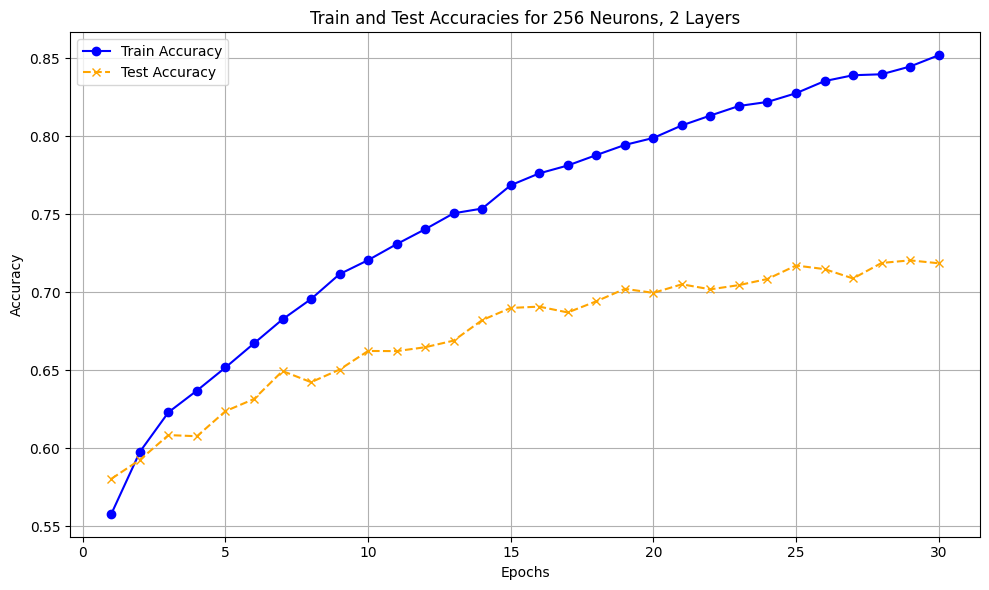

In [98]:
optimal_neurons = 256
optimal_layers = 2

plot_accuracies_over_epochs(cross_validation_accuracies['train_acc'], cross_validation_accuracies['test_acc'], optimal_neurons, optimal_layers)

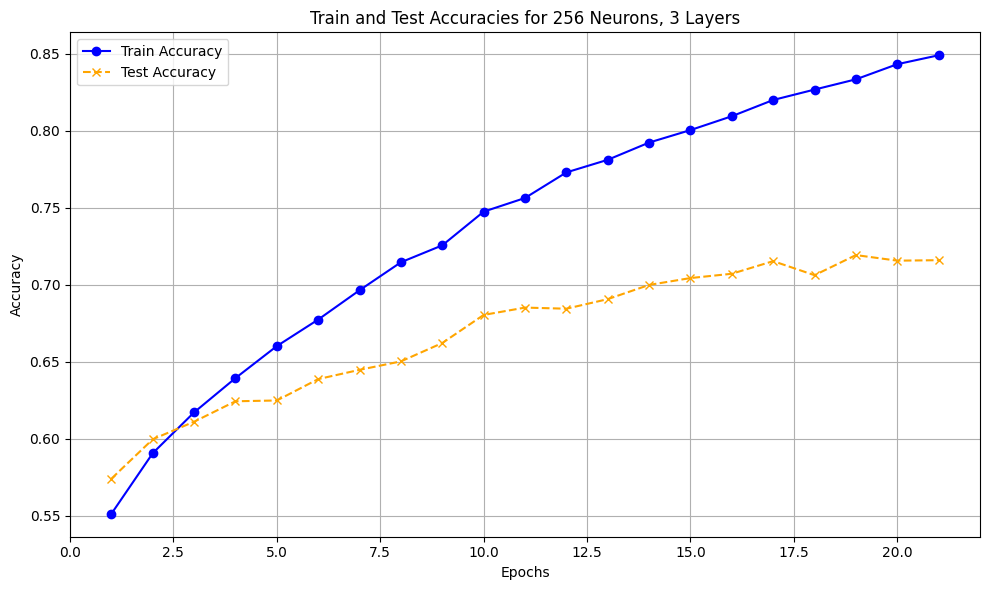

In [99]:
second_optimal_neurons = 256
second_optimal_layers = 3

plot_accuracies_over_epochs(cross_validation_accuracies['train_acc'], cross_validation_accuracies['test_acc'], second_optimal_neurons, second_optimal_layers)

7.As you've astutely observed, we're facing a significant challenge in enumerating all possible combinations of widths and depths and searching over them. Given the circumstances, could you explore and implement a more efficient method for searching through these combinations that could significantly reduce the computational time but achieve similar search results?

In [115]:
import torch
import torch.nn as nn
from ray import air, tune
from ray.tune.schedulers import HyperBandScheduler
from ray.air import session  # Correct import for session

# Define your search space
search_space = {
    "neurons": tune.choice([64, 128, 256]),
    "layers": tune.choice([1, 2, 3]),
    "batch_size": 256,  # You can also tune batch size if needed
    "lr": tune.loguniform(1e-4, 1e-1),  # Learning rate search space
    "patience": tune.choice([5, 10]),  # Early stopping patience
    "min_delta": tune.choice([1e-4, 1e-5])  # Minimum change in validation loss for early stopping
}

# Your train function that is used by ray.tune
def train(config, X_train_scaled, y_train, X_val_scaled, y_val):
    try:
        model = MLP(77, no_hidden=config["neurons"], no_labels=1, depth=config["layers"])
        train_dataloader, test_dataloader = intialise_dataloader(
            X_train_scaled, y_train, X_val_scaled, y_val, config["batch_size"]
        )
        optimizer = torch.optim.Adam(model.parameters(), lr=config["lr"])
        early_stopper = EarlyStopper(patience=config["patience"], min_delta=config["min_delta"])

        for epoch in range(100):  # Maximum number of epochs
            train_loss_, train_acc_ = training_loop(train_dataloader, model, loss_fn, optimizer)
            test_loss_, test_acc_ = validation_loop(test_dataloader, model, loss_fn)

            # Report results back using session.report()
            session.report({"accuracy": test_acc_, "loss": test_loss_})

            if early_stopper.early_stop(test_loss_):
                print(f"Early stopping at epoch {epoch}")
                break
    except Exception as e:
        print(f"Error in trial: {e}")
        raise e

# Define the Hyperband optimization routine
def find_optimal_hyperparameter_with_hyperband(X_train_scaled, y_train, X_val_scaled, y_val):
    # Define the Hyperband scheduler
    hyperband_scheduler = HyperBandScheduler(max_t=100, time_attr="training_iteration", reduction_factor=3)

    # Run the hyperparameter search using Hyperband
    analysis = tune.run(
        tune.with_parameters(train, X_train_scaled=X_train_scaled, y_train=y_train, 
                             X_val_scaled=X_val_scaled, y_val=y_val),
        config=search_space,  # Search space for Hyperband to explore
        metric="accuracy",  # Optimize for accuracy
        mode="max",  # Maximize the accuracy metric
        scheduler=hyperband_scheduler,  # Use Hyperband as the scheduler
        num_samples=10,  # Number of trials to sample
        resources_per_trial={"cpu": 1, "gpu": 0},  # Adjust resources based on available hardware
    )

    # Return the best hyperparameters found
    print("Best hyperparameters found:", analysis.best_config)
    return analysis.best_config

# Call the function to perform hyperparameter optimization
best_config = find_optimal_hyperparameter_with_hyperband(X_train_scaled, y_train, X_test_scaled, y_test)


2024-10-06 00:22:49,536	INFO tune.py:616 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


Trial name,accuracy,loss
train_10396_00000,0.647595,0.630462
train_10396_00001,0.745439,0.580682
train_10396_00002,0.65257,0.643956
train_10396_00003,0.664594,0.619142
train_10396_00004,0.547678,0.821808
train_10396_00005,0.624793,0.720596
train_10396_00006,0.695688,0.589884
train_10396_00007,0.695688,0.59386
train_10396_00008,0.687396,0.598459
train_10396_00009,0.547678,0.704392


2024-10-06 00:23:16,047	INFO hyperband.py:543 -- Restoring from a previous point in time. Previous=33; Now=1
2024-10-06 00:23:18,711	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to 'C:/Users/Belvedere Song/ray_results/train_2024-10-06_00-22-49' in 0.0330s.
2024-10-06 00:23:18,725	INFO tune.py:1041 -- Total run time: 29.19 seconds (29.13 seconds for the tuning loop).


Best hyperparameters found: {'neurons': 256, 'layers': 2, 'batch_size': 256, 'lr': 0.0029978142834241857, 'patience': 5, 'min_delta': 0.0001}


Using Hyperband, we found the best hyperparameters  to be 
- neurons: 256 
- layers: 2 
- lr: 0.0029978142834241857
- patience: 5
- min_delta: 0.0001

which is similar to the hyperparameters found earlier 

Hyperband is an extension of Successive Halving which achieve efficient hyperparamater optimization by balancing exploration (i.e. training many different configurations for a few epochs then gradually eliminates poorly performing configuration, focusing compuational resources on the better-performing configurations.)

